In [1]:
import os
import logging
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table, join, unique, vstack

matched = {}
for run in ['north','south']:
    output_dir = os.path.join(os.getenv('CSCRATCH'),'legacysim','dr9','SV3_tsmarg2mag',run)
    path_legacysim = os.path.join(output_dir,'file0_rs0_skip0','merged','matched_input.fits')
    legacysim = Table.read(path_legacysim)
    print('Found {:d}/{:d} matches.'.format(legacysim['matched'].sum(),len(legacysim)))
    matched[run] = legacysim[legacysim['matched']]

Found 4279/10268 matches.
Found 5832/11350 matches.


In [2]:
def isELG_colors(gflux=None, rflux=None, zflux=None, w1flux=None,
                 w2flux=None, gfiberflux=None, south=True, primary=None,
                 gmarg=0., grmarg=0., rzmarg=0.):
    """
    Apply ELG selection with box enlarged by ``gmarg``, ``grmarg``, ``rzmarg``.

    SV3 selection from https://github.com/desihub/desitarget/blob/7786db0931d23ed20de7ef37a6f07a52072e11ab/py/desitarget/sv3/sv3_cuts.py#L526
    """
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    elg = primary.copy()

    # ADM work in magnitudes instead of fluxes. NOTE THIS IS ONLY OK AS
    # ADM the snr masking in ALL OF g, r AND z ENSURES positive fluxes.
    g = 22.5 - 2.5*np.log10(gflux.clip(1e-16))
    r = 22.5 - 2.5*np.log10(rflux.clip(1e-16))
    z = 22.5 - 2.5*np.log10(zflux.clip(1e-16))
    gfib = 22.5 - 2.5*np.log10(gfiberflux.clip(1e-16))

    # ADM cuts shared by the northern and southern selections.
    elg &= g > 20 - gmarg                # bright cut.
    elg &= r - z > 0.15 - rzmarg         # blue cut.
#    elg &= r - z < 1.6 + rzmarg         # red cut.

    # ADM cuts that are unique to the north or south. Identical for sv3
    # ADM but keep the north/south formalism in case we use it later.
    if south:
        elg &= gfib < 24.1 + gmarg  # faint cut.
        elg &= g - r < 0.5*(r - z) + 0.1 + grmarg  # remove stars, low-z galaxies.
    else:
        elg &= gfib < 24. + gmarg  # faint cut.
        elg &= g - r < 0.5*(r - z) + 0.1 + grmarg  # remove stars, low-z galaxies.

    # ADM separate a low-priority and a regular sample.
    #elgvlo = elg.copy()

    # ADM low-priority OII flux cut.
    #elgvlo &= g - r < -1.2*(r - z) + 1.6 + grmarg
    #elgvlo &= g - r >= -1.2*(r - z) + 1.3 - grmarg
    elg &= g - r < -1.2*(r - z) + 1.6 + grmarg

    # ADM high-priority OII flux cut.
    #elg &= g - r < -1.2*(r - z) + 1.3 + grmarg

    return elg
    

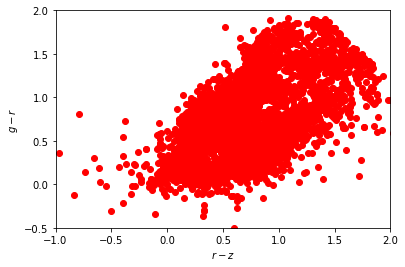

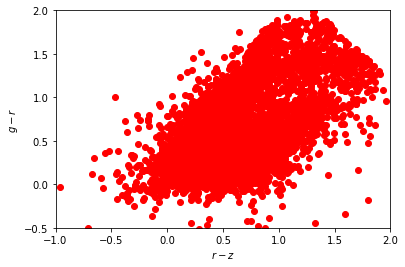

In [3]:
for run in matched:
    ax = plt.gca()
    ax.scatter(matched[run]['input_r'] - matched[run]['input_z'], matched[run]['input_g'] - matched[run]['input_r'], color='r')
    ax.set_xlim(-1.,2.)
    ax.set_ylim(-0.5,2.)
    ax.set_xlabel('$r-z$')
    ax.set_ylabel('$g-r$')
    plt.show()

In [4]:
def mag_to_flux(x):
    return 10.**(x/(-2.5)+9.)
    
def mask_colors(matched, input=True, gmarg=0., grmarg=0., rzmarg=0., run='south'):
    if input:
        gflux = mag_to_flux(matched['input_g'])
        rflux = mag_to_flux(matched['input_r'])
        zflux = mag_to_flux(matched['input_z'])
        gfiberflux = mag_to_flux(matched['input_gfiber'])
    else:
        gflux = matched['flux_g']/matched['mw_transmission_g']
        rflux = matched['flux_r']/matched['mw_transmission_r']
        zflux = matched['flux_z']/matched['mw_transmission_z']
        gfiberflux = matched['fiberflux_g']/matched['mw_transmission_g']
    return isELG_colors(gflux=gflux, rflux=rflux, zflux=zflux, gfiberflux=gfiberflux, south=run=='south', gmarg=gmarg, grmarg=grmarg, rzmarg=rzmarg)
    
def enlarge_ts_box(matched, scatter_threshold=0.01, step=0.01, run='north'):
    
    output_in_nominal_box = mask_colors(matched, input=False, gmarg=0., grmarg=0., rzmarg=0., run=run)
    output_finite = mask_colors(matched, input=False, gmarg=np.inf, grmarg=np.inf, rzmarg=np.inf, run=run)
    input_in_nominal_box = mask_colors(matched, input=True, gmarg=0., grmarg=0., rzmarg=0., run=run)
    input_not_in_nominal_box = output_in_nominal_box & ~input_in_nominal_box
    output_not_in_nominal_box = input_in_nominal_box & output_finite & ~output_in_nominal_box
    noutput_in_nominal_box = output_in_nominal_box.sum()
    scatter_fraction = input_not_in_nominal_box.sum()*1./noutput_in_nominal_box
    contamination_fraction = output_not_in_nominal_box.sum()*1./noutput_in_nominal_box
    
    list_scatter_fraction = [scatter_fraction]
    list_contamination_fraction = [contamination_fraction]
    cuts = ['gmarg','grmarg','rzmarg']
    margins = {cut:0. for cut in cuts}
    list_margins = [margins.copy()]
    
    while scatter_fraction > scatter_threshold:
        cscatter_fraction = []
        input_in_box = mask_colors(matched, input=True, run=run, **margins)
        for cut in cuts:
            cmargins = margins.copy()
            cmargins[cut] = np.inf
            input_not_in_nominal_box = output_in_nominal_box & mask_colors(matched, input=True, run=run, **cmargins) & ~input_in_box
            cscatter_fraction.append(input_not_in_nominal_box.sum()*1./noutput_in_nominal_box)
        # update color cut with largest scatter fraction
        cut = cuts[np.argmax(cscatter_fraction)]
        margins[cut] = margins[cut] + step
        input_in_box = mask_colors(matched, input=True, run=run, **margins)
        input_not_in_box = output_in_nominal_box & ~input_in_box
        output_not_in_box = input_in_box & output_finite & ~output_in_nominal_box
        scatter_fraction = input_not_in_box.sum()*1./noutput_in_nominal_box
        contamination_fraction = output_not_in_box.sum()*1./noutput_in_nominal_box
        list_scatter_fraction.append(scatter_fraction)
        list_contamination_fraction.append(contamination_fraction)
        list_margins.append(margins.copy())
    
    return list_scatter_fraction, list_contamination_fraction, list_margins

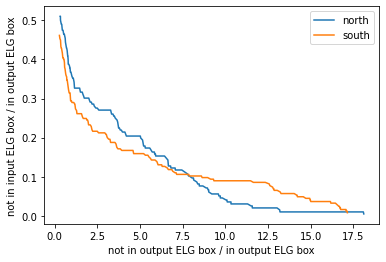

In [5]:
ax = plt.gca()
list_margins = {}
for run in matched:
    list_scatter_fraction, list_contamination_fraction, list_margins[run] = enlarge_ts_box(matched[run], scatter_threshold=0.01, step=0.01, run=run)
    ax.plot(list_contamination_fraction, list_scatter_fraction, label=run)
ax.set_ylabel('not in input ELG box / in output ELG box')
ax.set_xlabel('not in output ELG box / in output ELG box')
ax.legend()

In [6]:
run = 'north'
print(list_margins[run][-1])

{'gmarg': 1.9800000000000015, 'grmarg': 1.1700000000000008, 'rzmarg': 0.24000000000000007}


<ipython-input-7-a505ec91815e>:5: RuntimeWarning: divide by zero encountered in log10
  mag = 22.5 - 2.5*np.log10(matched[run]['flux_{}'.format(b)]/matched[run]['mw_transmission_{}'.format(b)])
<ipython-input-7-a505ec91815e>:5: RuntimeWarning: invalid value encountered in log10
  mag = 22.5 - 2.5*np.log10(matched[run]['flux_{}'.format(b)]/matched[run]['mw_transmission_{}'.format(b)])


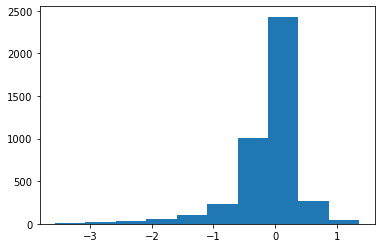

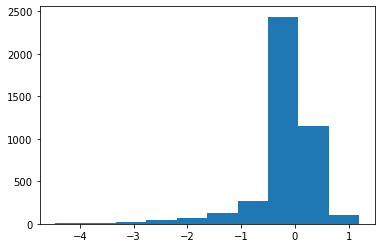

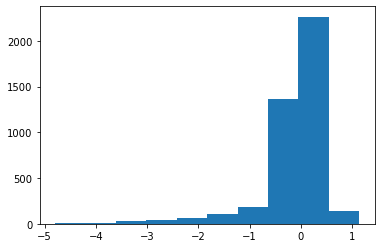

In [7]:
run = 'north'
#run = 'south'
for b in 'grz':
    ax = plt.gca()
    mag = 22.5 - 2.5*np.log10(matched[run]['flux_{}'.format(b)]/matched[run]['mw_transmission_{}'.format(b)])
    diff = mag - matched[run]['input_{}'.format(b)]
    diff = diff[np.isfinite(diff)]
    low,high = np.quantile(diff,q=(0.005,0.995))
    ax.hist(diff[(diff > low) & (diff < high)])
    plt.show()

In [8]:
#run = 'north'
#for margin in list_margins[run]:
#    print(margin)
for run in matched:
    mask0 = mask_colors(matched[run], input=True, run=run, gmarg=0.5, grmarg=0.5, rzmarg=0.5)
    mask = mask_colors(matched[run], input=True, run=run, **list_margins[run][-1])
    print(mask0.sum()*1./mask0.size, mask.sum()*1./mask.size, mask.size)

0.3528861883617668 0.8754381864921711 4279
0.32733196159122085 0.7623456790123457 5832
